In [1]:
import jax
from jax import lax, jit, vmap, random
import jax.numpy as jnp
import haiku as hk
import numpy as np
import string
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from encoder import Encoder

# ***Encoder Block***
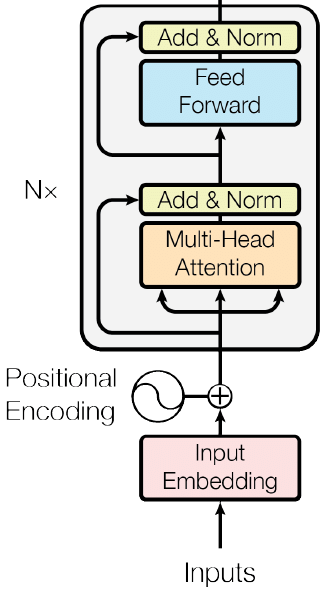

### ***1) Setting up a Toy Dataset*** 

In [2]:
SEED = 17
key = random.PRNGKey(SEED)

In [3]:
with open("data/dormeur_du_val.txt", "r", encoding="utf-8") as f:
    text = f.read().lower()
wo_punct = [letter for letter in text if letter not in string.punctuation]
tokens = "".join(wo_punct).split()
tokens[:9]

['cest', 'un', 'trou', 'de', 'verdure', 'où', 'chante', 'une', 'rivière']

In [4]:
SEQ_LEN = (10)
VOCAB_SIZE = (len(set(tokens)))
EMBED_DIM = (64)
BATCH_SIZE = (32)
SEED = (17)
N_HEADS = (4)
D_K = (int(EMBED_DIM / N_HEADS))
HIDDEN_DIM = 256

In [5]:
def collect_sequences(key:random.PRNGKey, data:list, seq_len:int, n_seq:int):
    """
    Samples n_seq random offsets and returns the same number of token sequences
    of length seq_len 
    """
    start_indexes = random.randint(key, (n_seq,), 0, len(data)-seq_len)
    return [data[start_indexes[i]: start_indexes[i] + seq_len] for i in range(n_seq)]

sequences = collect_sequences(key, tokens, SEQ_LEN, BATCH_SIZE)

In [6]:
token_to_indices = {token:idx for idx, token in enumerate(set(tokens))}
encode_tokens = lambda sequence: [token_to_indices[token] for token in sequence]
encoded_sequences = jnp.array(list(map(encode_tokens, sequences)))
encoded_sequences.shape

(32, 10)

In [7]:
@hk.transform
def encoder(x):
    model = Encoder(
        vocab_size=VOCAB_SIZE,
        embed_dim=EMBED_DIM,
        seq_len=SEQ_LEN,
        batch_size=BATCH_SIZE,
        n_heads=N_HEADS,
        d_k=D_K,
        hidden_dim=HIDDEN_DIM,
        name="Encoder_module"
    )
    return model(x)

key = jax.random.PRNGKey(0)

params = encoder.init(key, jnp.zeros((BATCH_SIZE, SEQ_LEN), dtype=jnp.int32))
outputs = encoder.apply(params, key, encoded_sequences)

In [8]:
outputs.shape

(32, 10, 64)

In [9]:
px.imshow(outputs[0], title="Output of the Encoder Block", labels=dict(x="Embedding dimension", y="Sequence Length"), color_continuous_scale="VIRIDIS")